In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.tools as tls
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import itertools
import warnings
import ast
import pickle

In [28]:
warnings.filterwarnings("ignore")

In [29]:
# Load the dataset
file_path = 'Carbon Emission.csv'
data = pd.read_csv(file_path)

In [30]:
# Display the first few rows of the dataset for initial assessment
data.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [31]:
# # Handle Missing Values
# data['Vehicle Type'].fillna('unknown', inplace=True)

In [32]:
# Fix Data Types
categorical_columns = ['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Transport', 'Vehicle Type', 
                       'Social Activity', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency', 'Recycling', 'Cooking_With']
for column in categorical_columns:
    if column in ['Recycling', 'Cooking_With']:
        data[column] = data[column].astype('object')  # Ensure these columns are treated as object types
    else:
        data[column] = data[column].astype('category')

# Convert the 'Recycling' and 'Cooking_With' columns from string representations of lists to actual lists
data['Recycling'] = data['Recycling'].apply(ast.literal_eval)
data['Cooking_With'] = data['Cooking_With'].apply(ast.literal_eval)

# Flatten the lists into comma-separated strings
data['Recycling'] = data['Recycling'].apply(lambda x: ','.join(x))
data['Cooking_With'] = data['Cooking_With'].apply(lambda x: ','.join(x))

# Create dummy variables for these transformed columns
recycling_dummies = data['Recycling'].str.get_dummies(sep=',')
cooking_with_dummies = data['Cooking_With'].str.get_dummies(sep=',')

# Concatenate the original data with the new dummy variables
data = pd.concat([data.drop(['Recycling', 'Cooking_With'], axis=1), recycling_dummies, cooking_with_dummies], axis=1)

# Standardize Text Columns
text_columns = data.select_dtypes(include=['object', 'category']).columns
data[text_columns] = data[text_columns].apply(lambda x: x.str.lower())

# Rename Columns
data.columns = data.columns.str.replace(' ', '_').str.lower()

# Summary statistics for numerical columns
numerical_summary = data.describe()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")


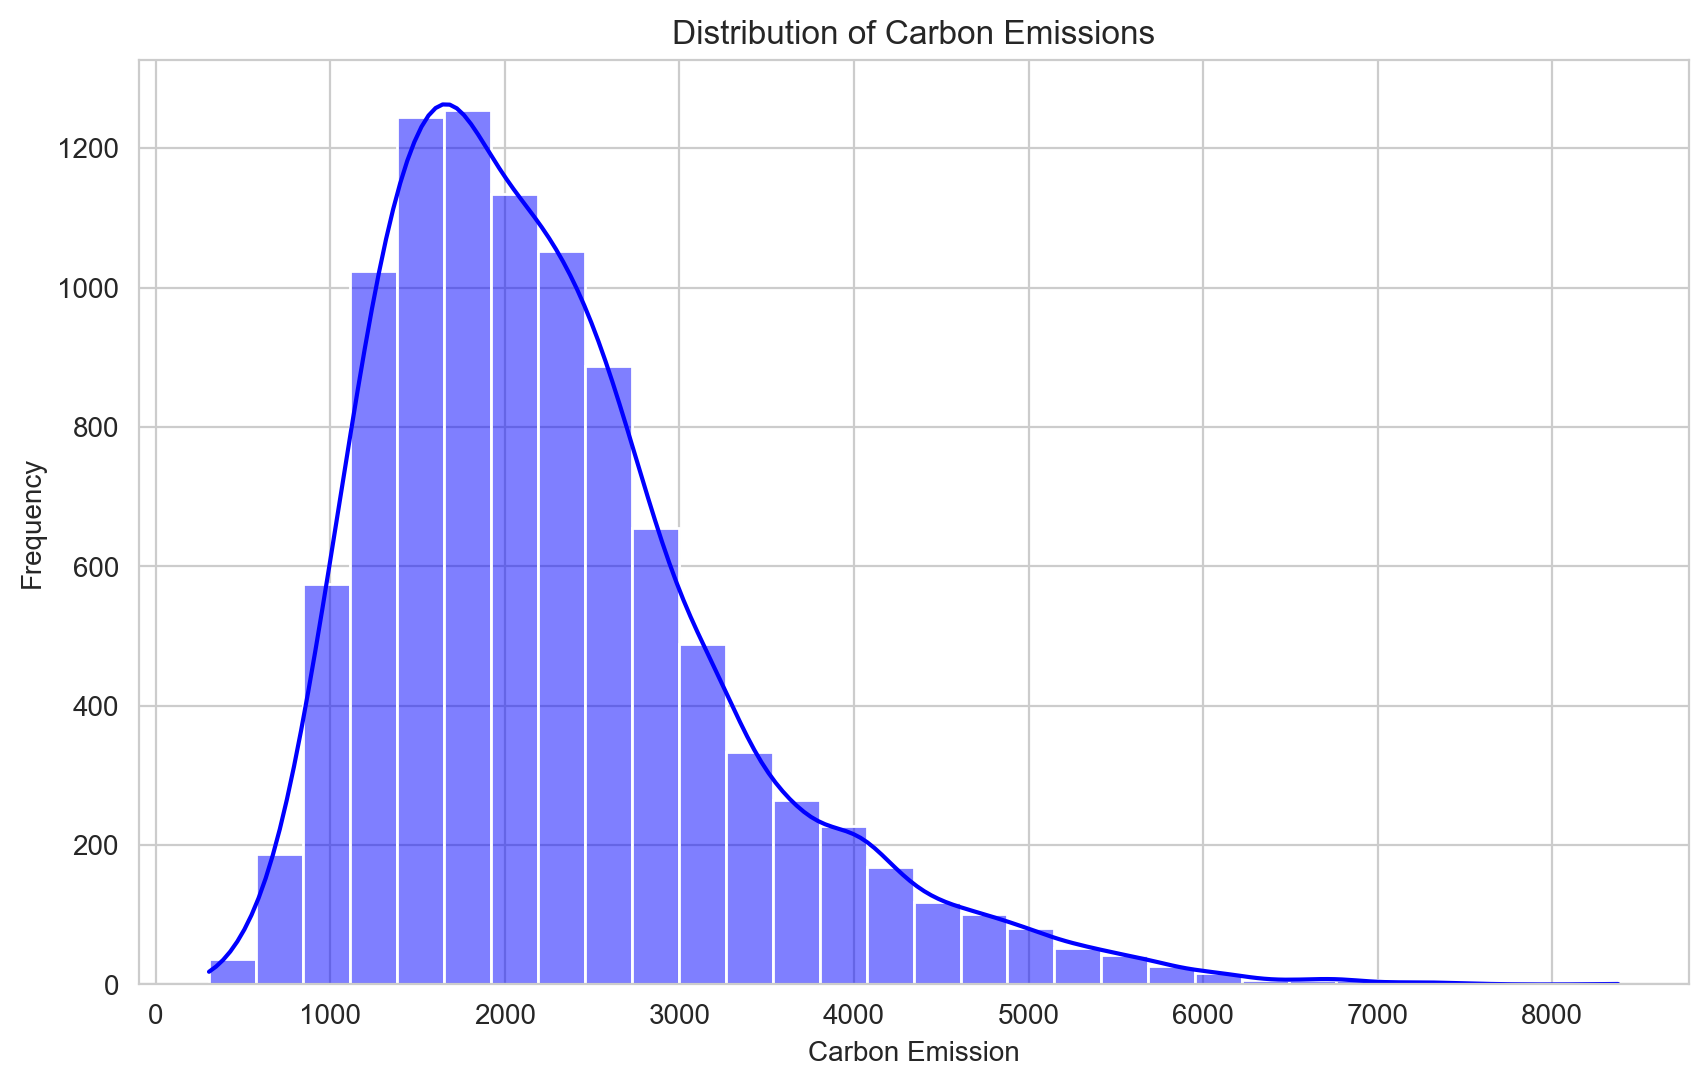

In [33]:
# Histogram of Carbon Emissions
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data['carbonemission'], kde=True, color='blue', bins=30)
plt.title('Distribution of Carbon Emissions')
plt.xlabel('Carbon Emission')
plt.ylabel('Frequency')
plt.show()


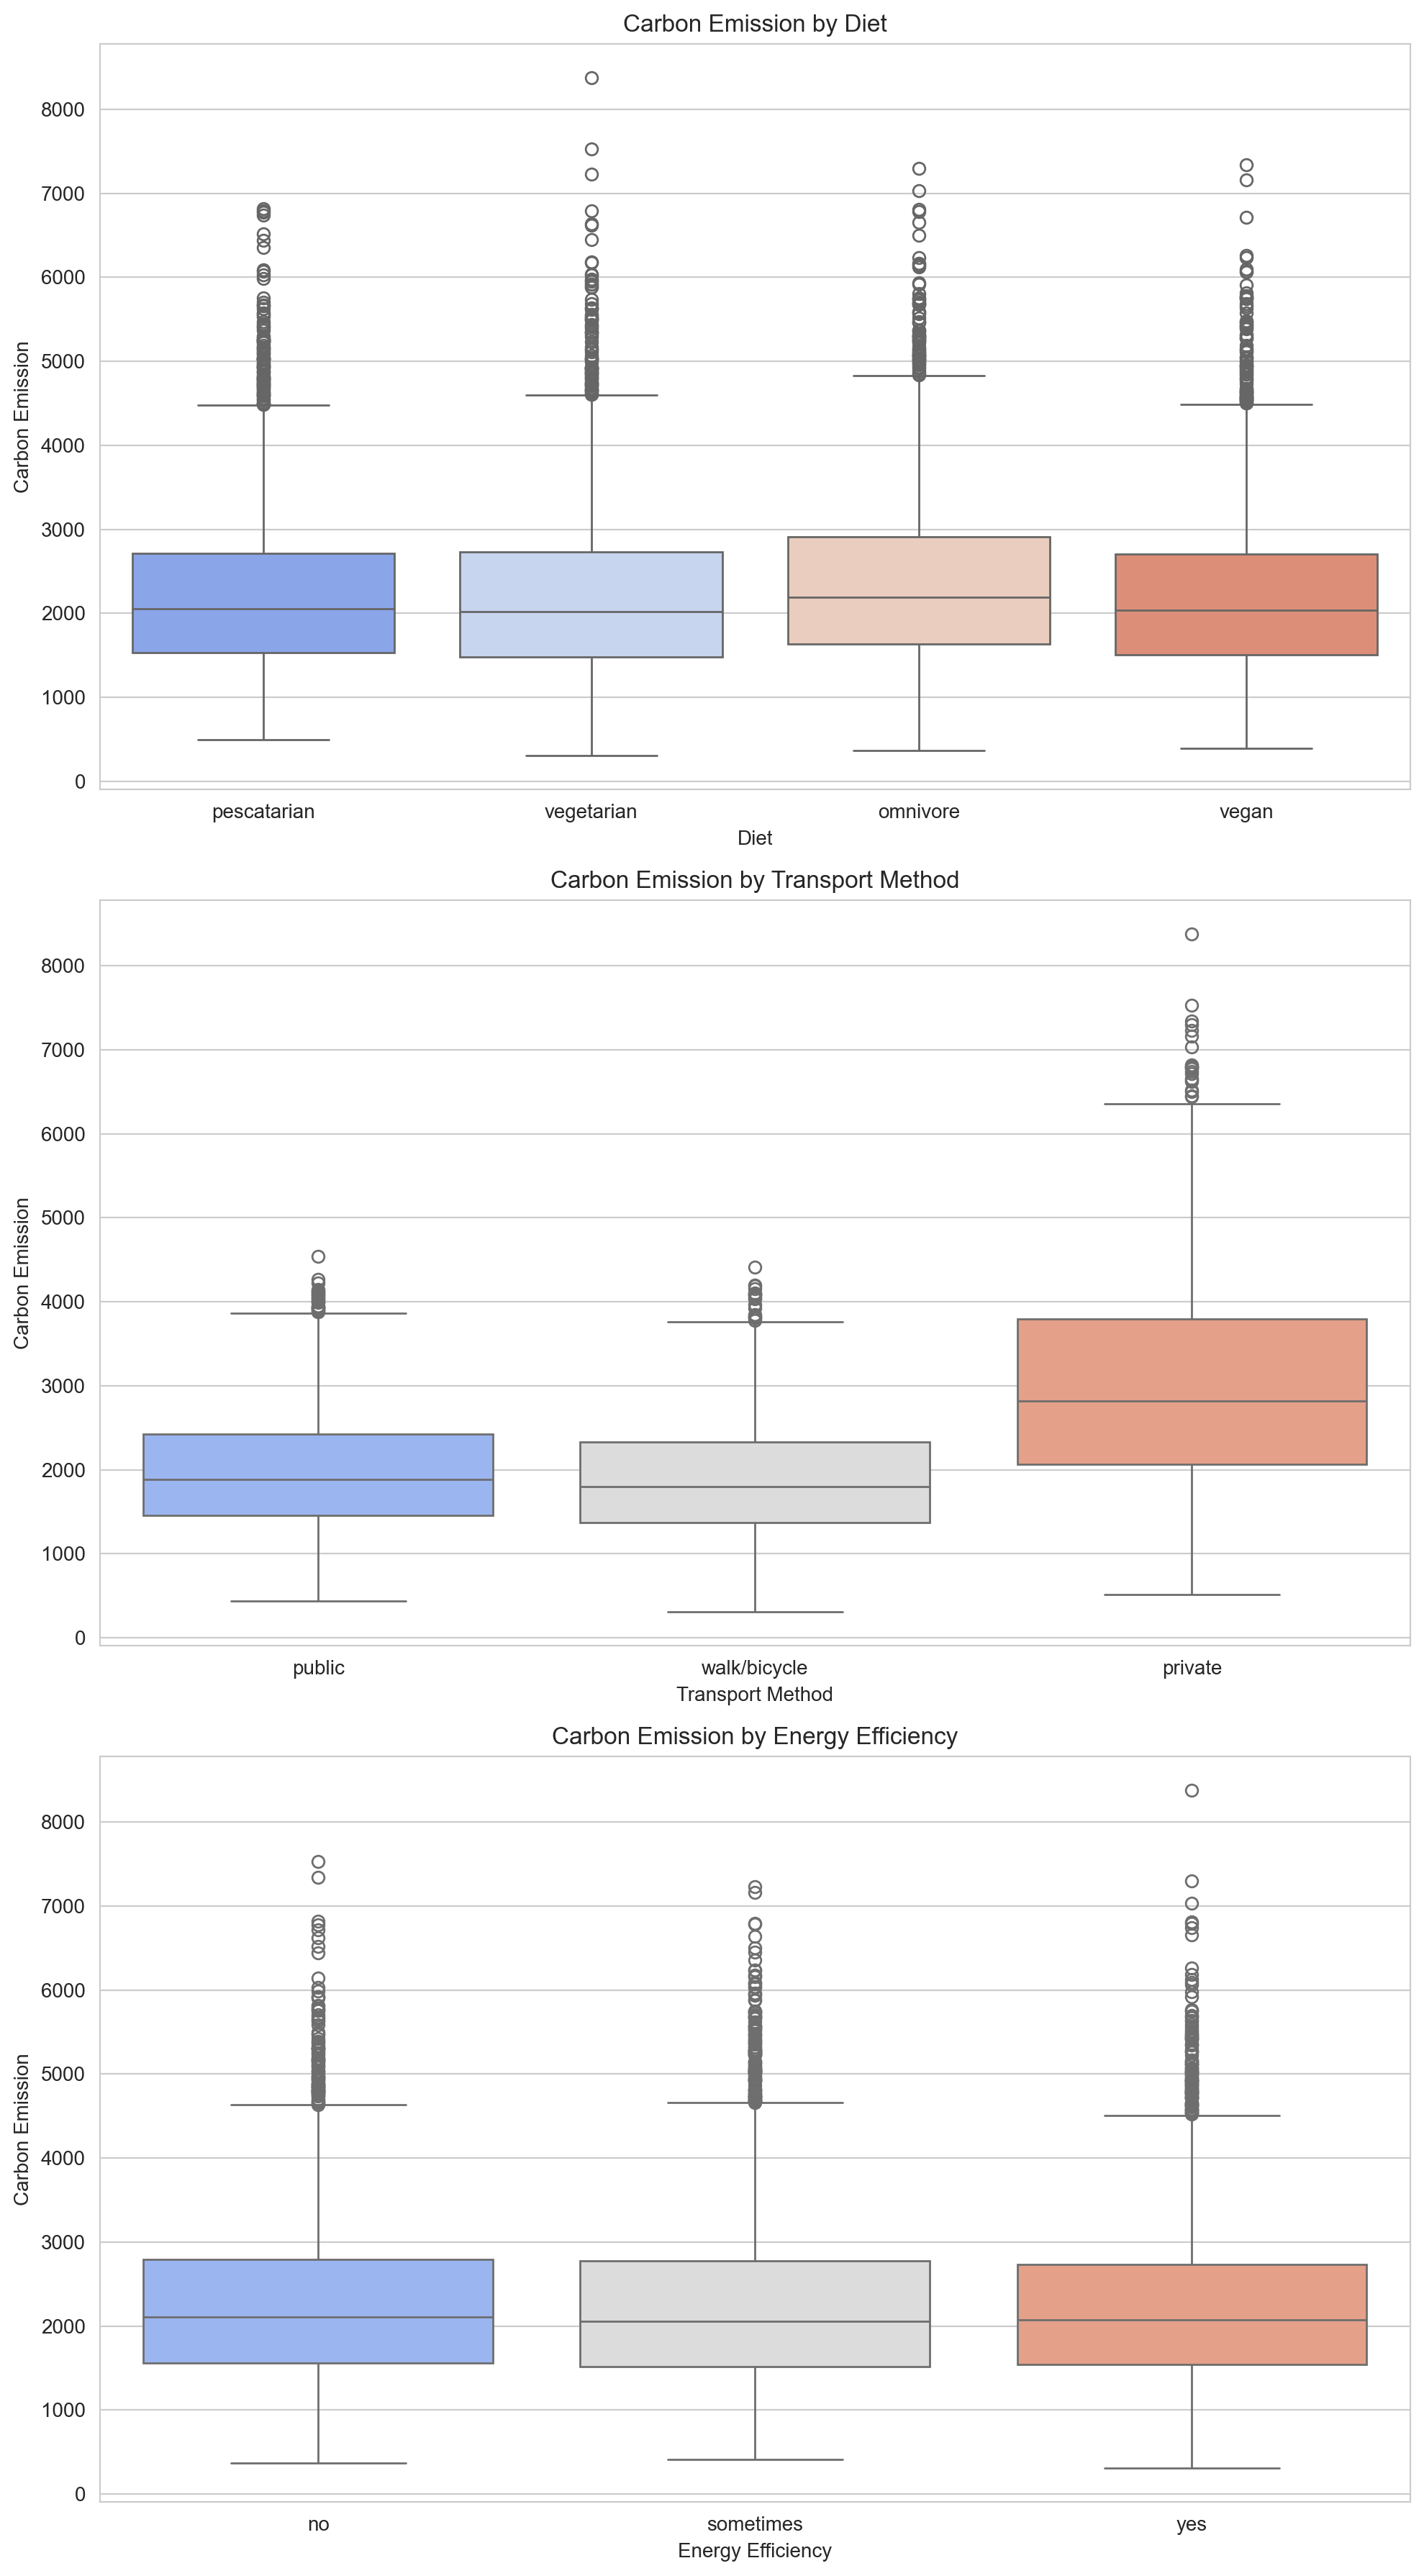

In [34]:
# Box plots for carbon emissions across different categories
fig, axes = plt.subplots(3, 1, figsize=(10, 18), dpi=200)
sns.boxplot(ax=axes[0], x='diet', y='carbonemission', data=data, palette="coolwarm")
axes[0].set_title('Carbon Emission by Diet')
axes[0].set_xlabel('Diet')
axes[0].set_ylabel('Carbon Emission')
sns.boxplot(ax=axes[1], x='transport', y='carbonemission', data=data, palette="coolwarm")
axes[1].set_title('Carbon Emission by Transport Method')
axes[1].set_xlabel('Transport Method')
axes[1].set_ylabel('Carbon Emission')
sns.boxplot(ax=axes[2], x='energy_efficiency', y='carbonemission', data=data, palette="coolwarm")
axes[2].set_title('Carbon Emission by Energy Efficiency')
axes[2].set_xlabel('Energy Efficiency')
axes[2].set_ylabel('Carbon Emission')
plt.tight_layout()
plt.show()


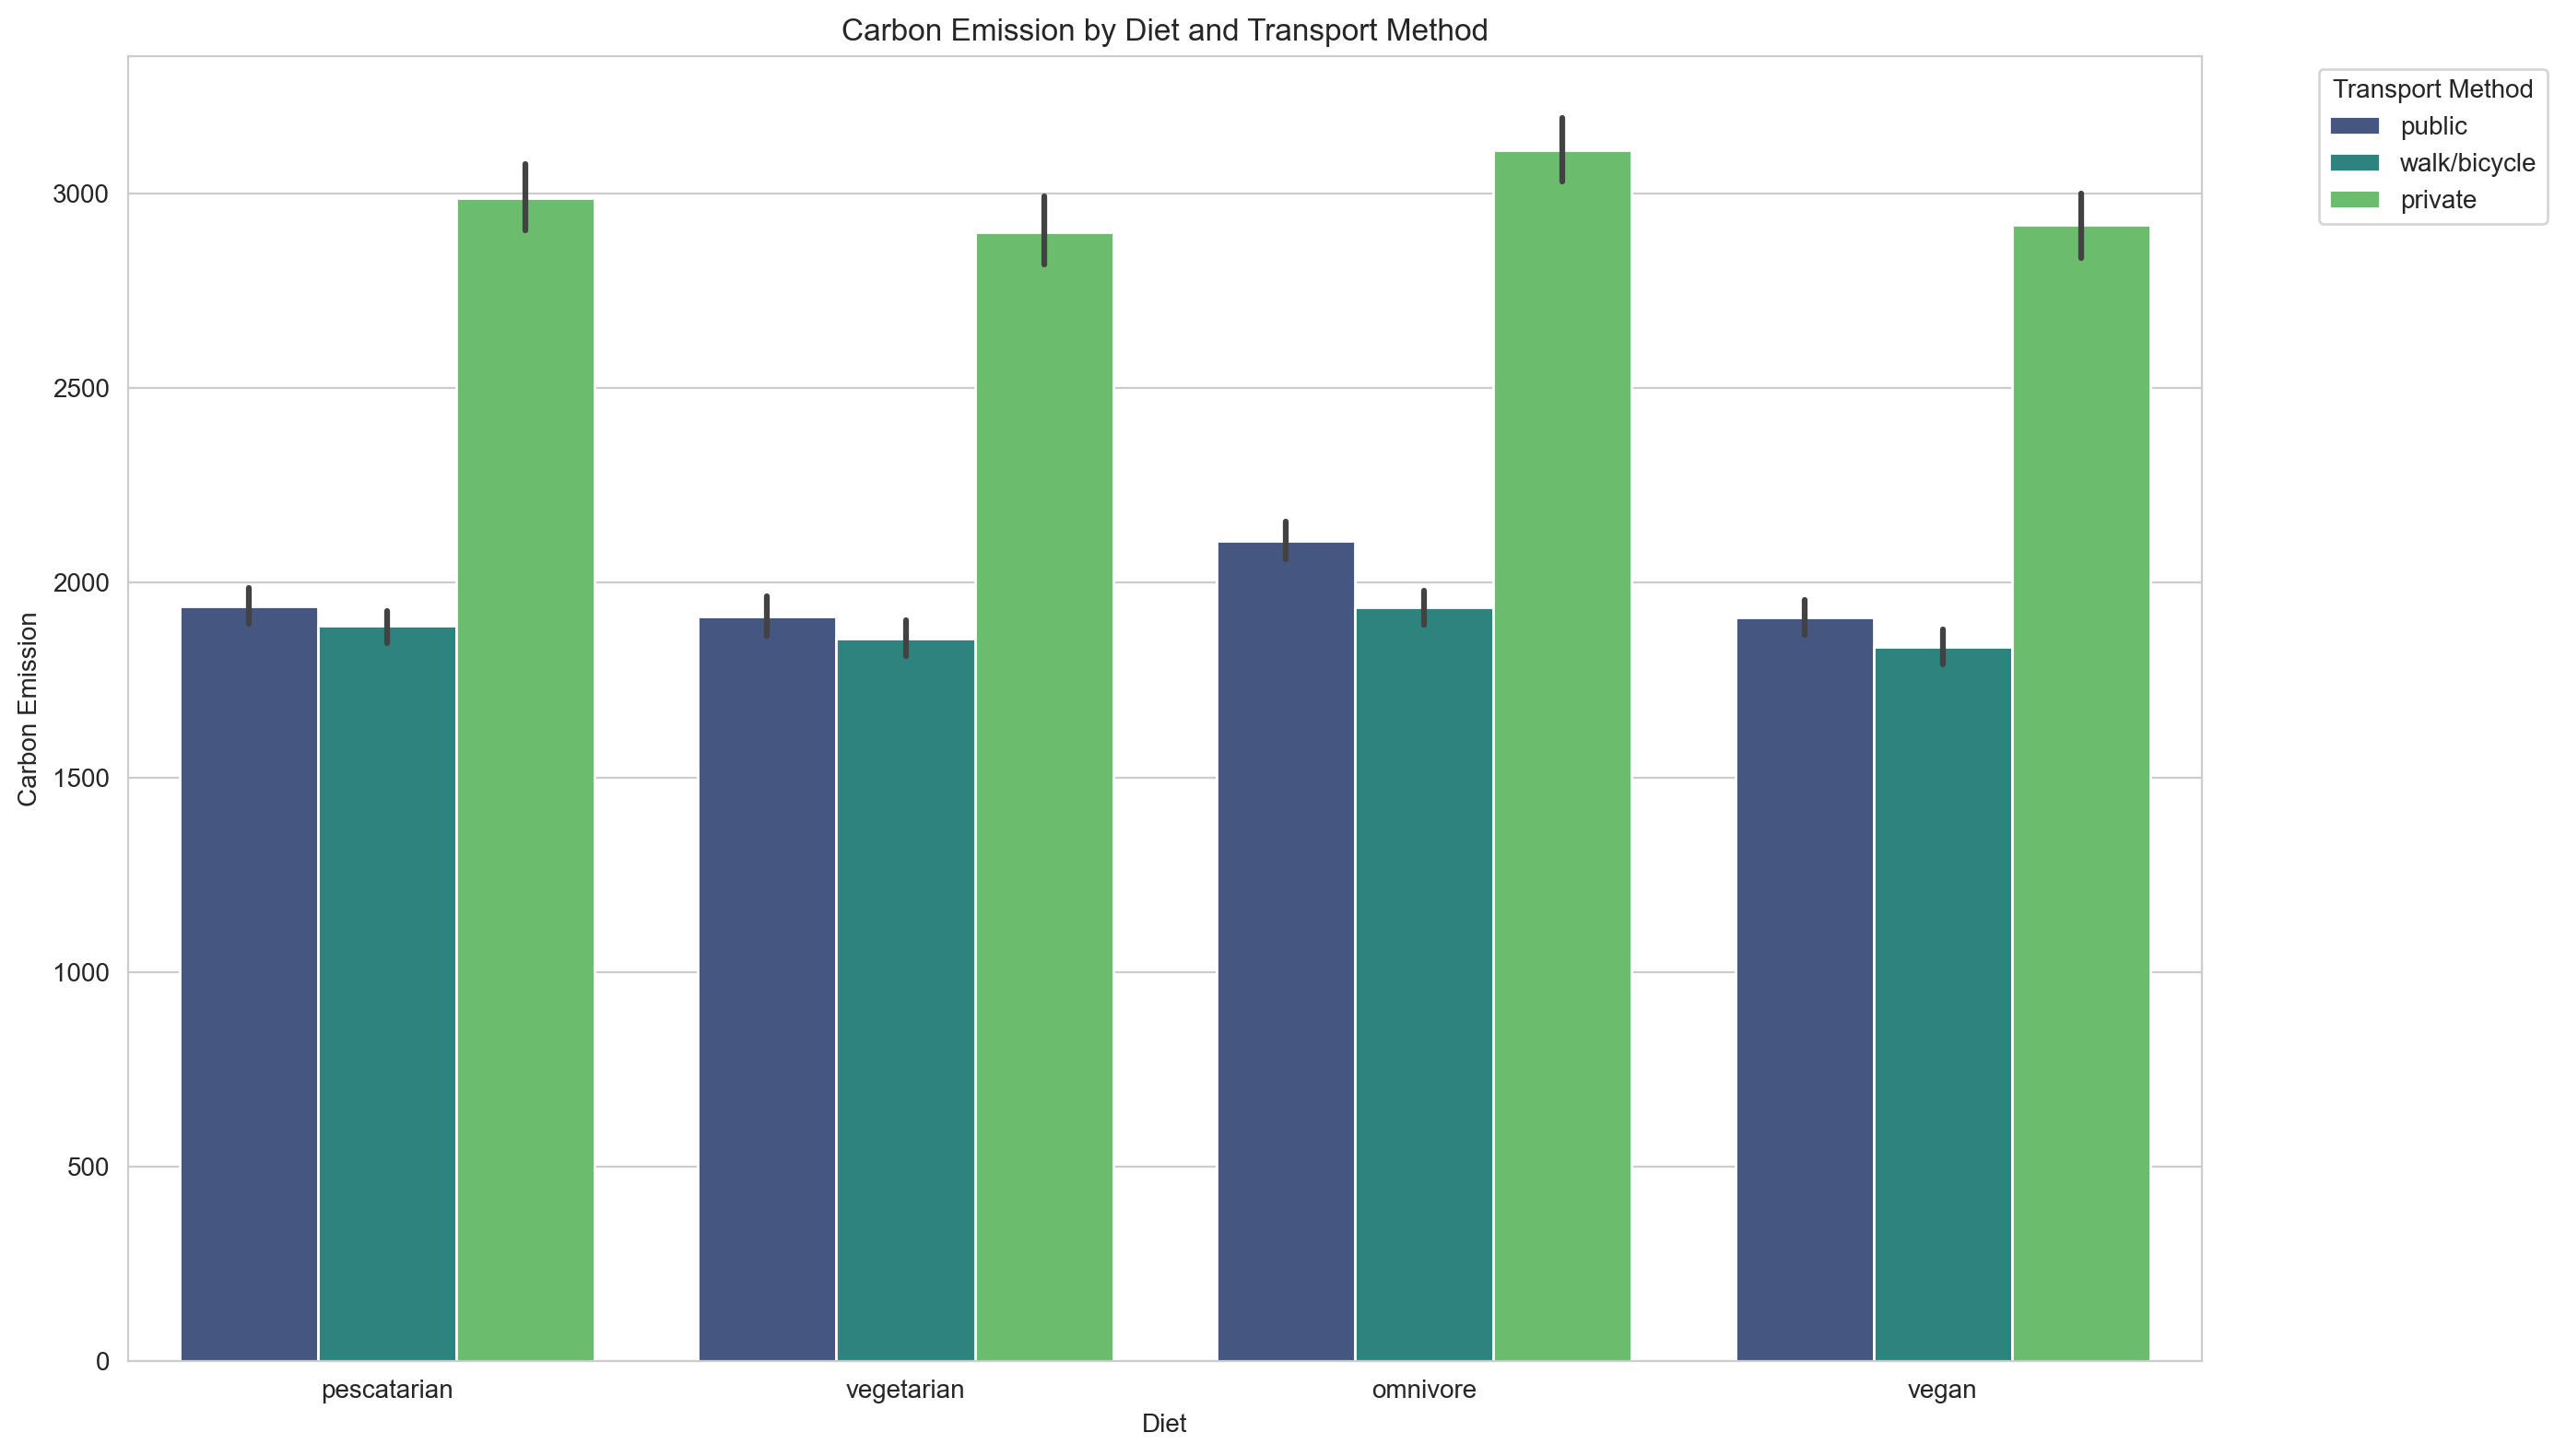

In [35]:
# Interaction between Diet and Transport Method on Carbon Emissions
plt.figure(figsize=(14, 8), dpi=200)
sns.barplot(x='diet', y='carbonemission', hue='transport', data=data, palette='viridis')
plt.title('Carbon Emission by Diet and Transport Method')
plt.xlabel('Diet')
plt.ylabel('Carbon Emission')
plt.legend(title='Transport Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


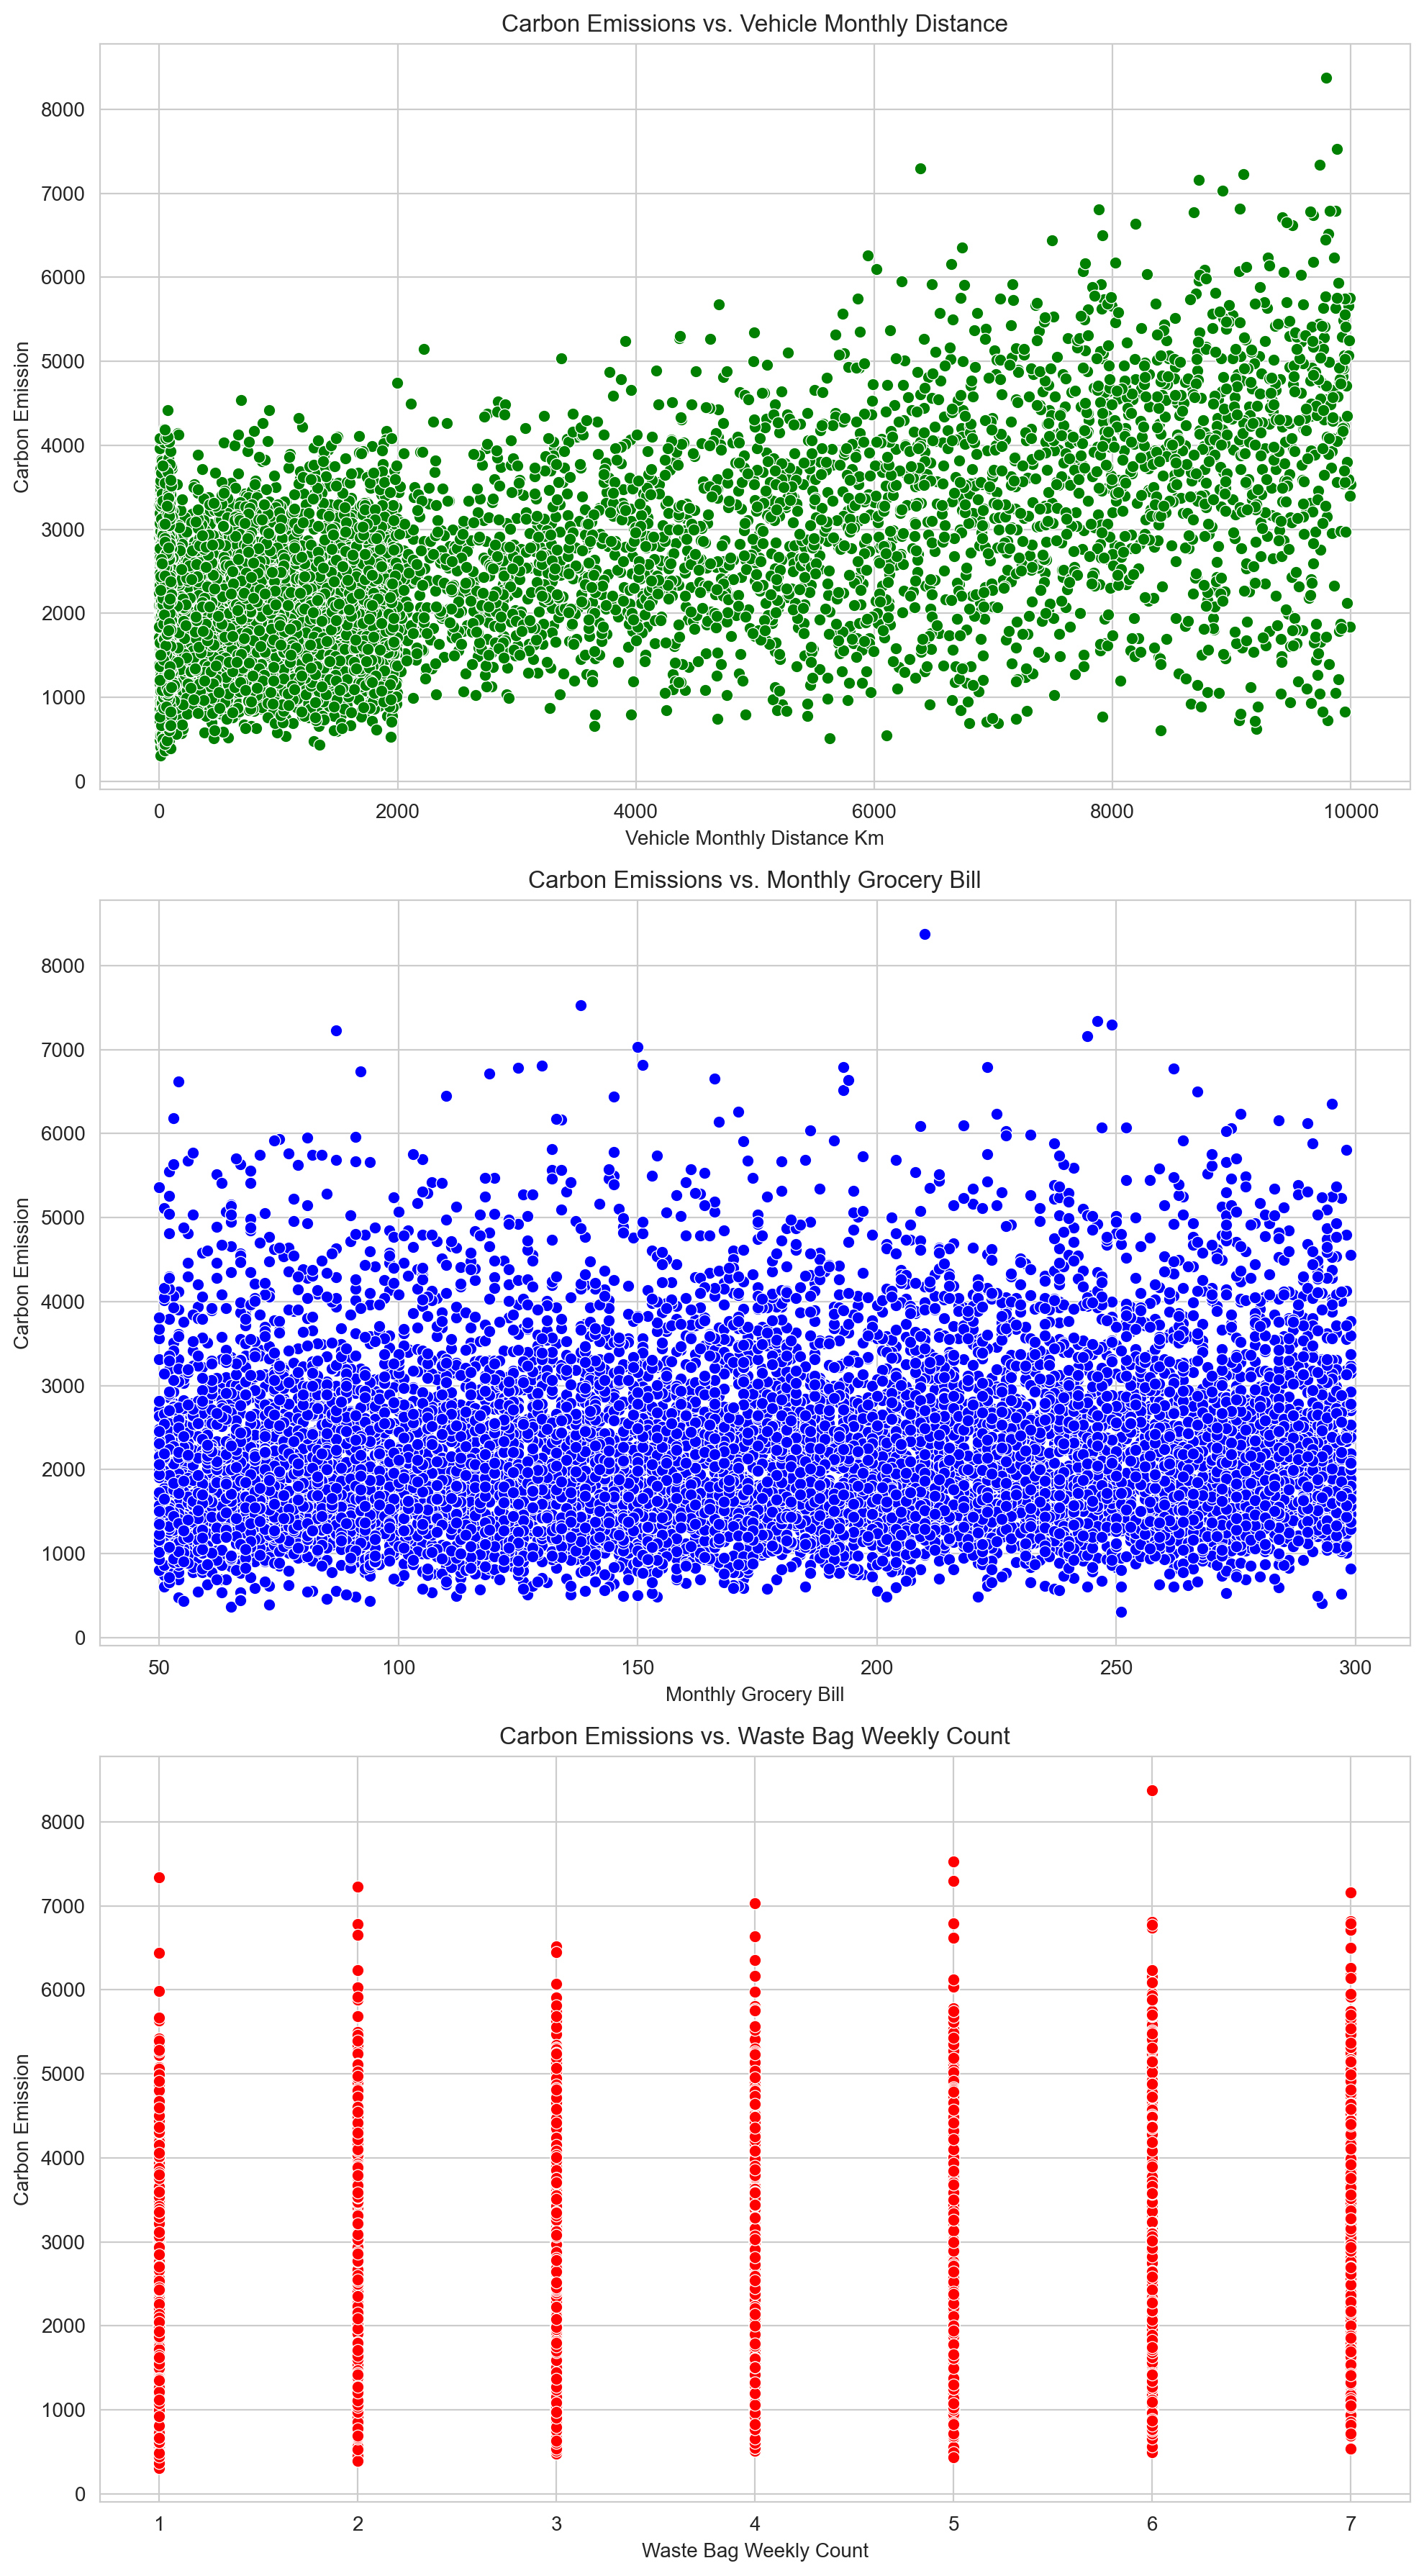

In [36]:
# Scatter plots for selected variable pairs
fig, axes = plt.subplots(3, 1, figsize=(10, 18), dpi=200)
sns.scatterplot(ax=axes[0], x='vehicle_monthly_distance_km', y='carbonemission', data=data, color='green')
axes[0].set_title('Carbon Emissions vs. Vehicle Monthly Distance')
axes[0].set_xlabel('Vehicle Monthly Distance Km')
axes[0].set_ylabel('Carbon Emission')
sns.scatterplot(ax=axes[1], x='monthly_grocery_bill', y='carbonemission', data=data, color='blue')
axes[1].set_title('Carbon Emissions vs. Monthly Grocery Bill')
axes[1].set_xlabel('Monthly Grocery Bill')
axes[1].set_ylabel('Carbon Emission')
sns.scatterplot(ax=axes[2], x='waste_bag_weekly_count', y='carbonemission', data=data, color='red')
axes[2].set_title('Carbon Emissions vs. Waste Bag Weekly Count')
axes[2].set_xlabel('Waste Bag Weekly Count')
axes[2].set_ylabel('Carbon Emission')
plt.tight_layout()
plt.show()


In [37]:
# Selecting features for clustering
features = data[['vehicle_monthly_distance_km', 'monthly_grocery_bill', 'waste_bag_weekly_count', 
                 'how_long_tv_pc_daily_hour', 'how_many_new_clothes_monthly', 'how_long_internet_daily_hour']]

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)



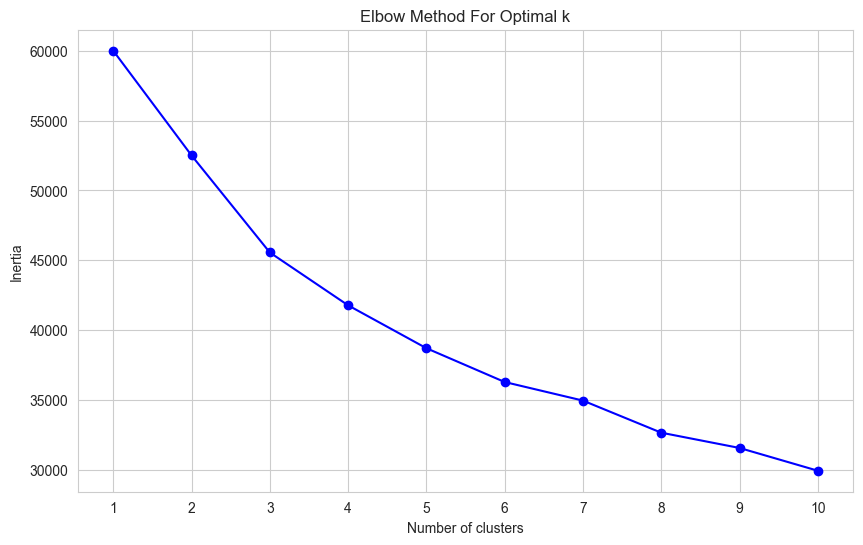

In [38]:
from sklearn.cluster import KMeans
# Determine the Number of Clusters using the Elbow Method
inertia = []
K_range = range(1, 11)
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.show()


In [39]:
# Perform K-means clustering with K=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adding the cluster labels to the original dataframe for further analysis
data['cluster'] = clusters


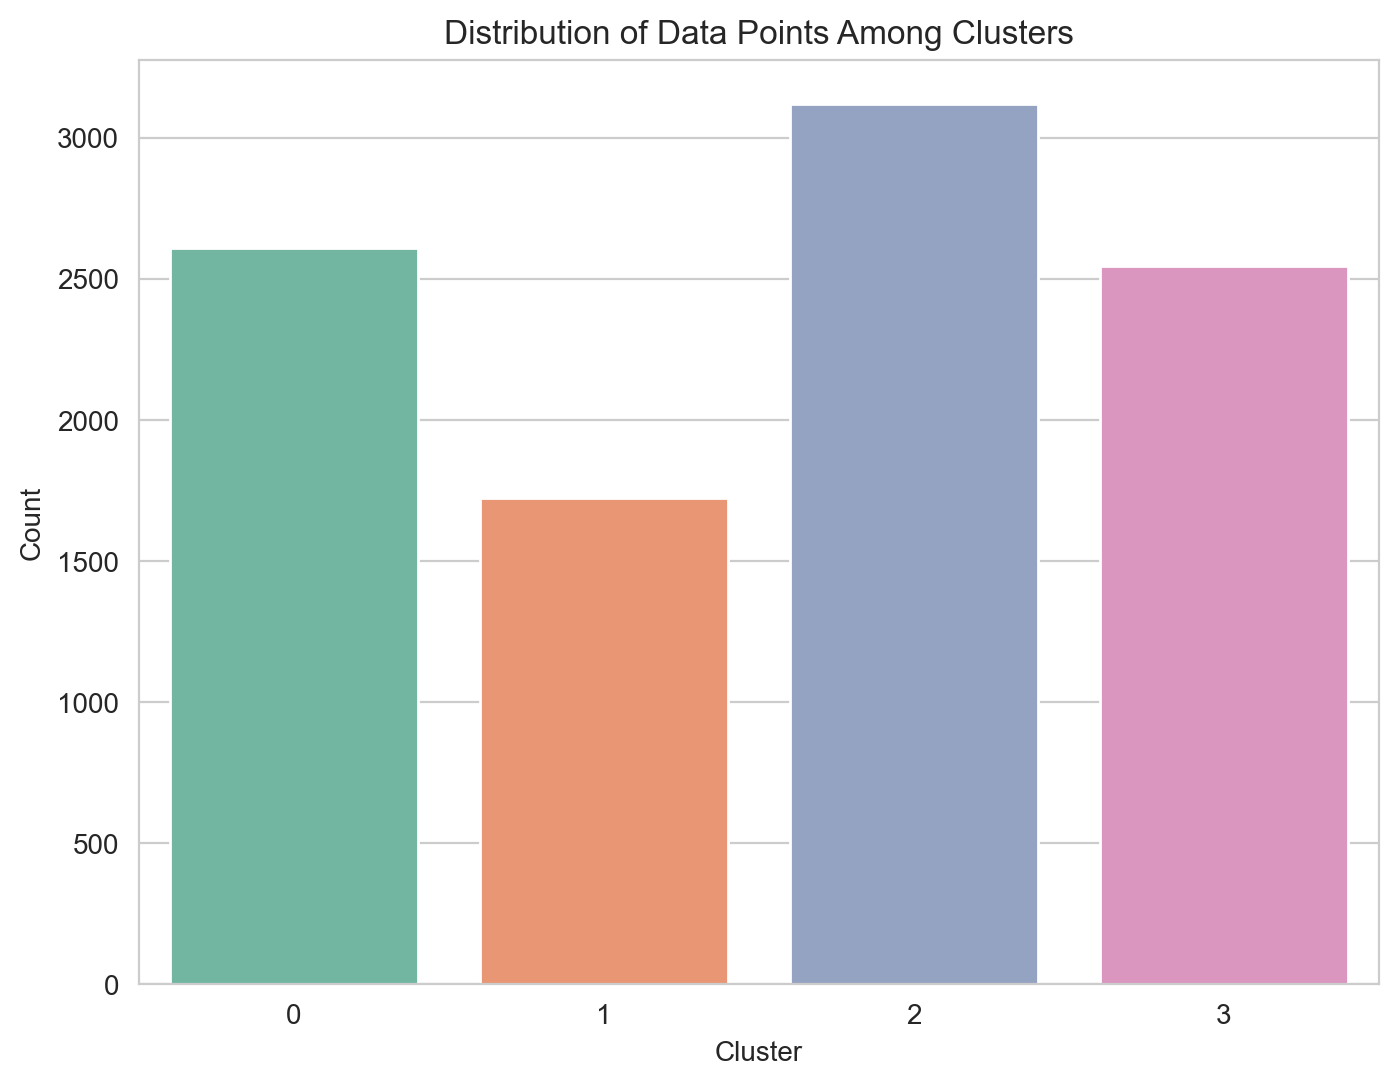

In [40]:
# Visualizing the distribution of data points among the 4 clusters
plt.figure(figsize=(8, 6), dpi=200, edgecolor='black')
sns.countplot(x='cluster', data=data, palette='Set2')
plt.title('Distribution of Data Points Among Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [41]:
# Returning the first few rows of the dataframe with the cluster assignments
data.head()


,body_type,sex,diet,how_often_shower,heating_energy_source,transport,vehicle_type,social_activity,monthly_grocery_bill,frequency_of_traveling_by_air,...,glass,metal,paper,plastic,airfryer,grill,microwave,oven,stove,cluster
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,...,0,1,0,0,0,0,0,1,1,3
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,...,0,1,0,0,0,0,1,0,1,2
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,...,0,1,0,0,0,0,1,1,0,2
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,...,1,1,1,1,1,1,1,0,0,2
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,...,0,0,1,0,0,0,0,1,0,1


In [42]:
# Model Training and Evaluation
X = data.drop(columns=['carbonemission'])
y = data['carbonemission']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['category', 'object']).columns

# Apply one-hot encoding to categorical columns
X = pd.get_dummies(X, columns=categorical_columns)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
# Define models
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regression', DecisionTreeRegressor()),
    ('Support Vector Regression', SVR(kernel='rbf')),
    ('Random Forest Regression', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('AdaBoost Regression', AdaBoostRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting Regression', GradientBoostingRegressor()),
    ('XGB Regression', XGBRegressor()),
    ('LGBM Regression', LGBMRegressor(verbose=-1)),
    ('CatBoost Regression', CatBoostRegressor(verbose=False))
]


In [44]:
# Train and evaluate models
results = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append((name, r2, mae))

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'R2 Score', 'Mean Absolute Error'])
print(results_df)


                          Model  R2 Score  Mean Absolute Error
0             Linear Regression  0.936113           177.777339
1      Decision Tree Regression  0.817581           335.512500
2     Support Vector Regression  0.056544           740.404853
3      Random Forest Regression  0.923694           217.585350
4           AdaBoost Regression  0.779945           408.266272
5  Gradient Boosting Regression  0.958656           156.287805
6                XGB Regression  0.973787           126.466370
7               LGBM Regression  0.979183           113.327541
8           CatBoost Regression  0.992795            63.944746


In [45]:
# Find the best ML model
best_ml_model_name, best_ml_r2, best_ml_mae = min(results, key=lambda x: x[2])
print(f"\nBest ML Model: {best_ml_model_name} with MAE: {best_ml_mae:.4f}")



Best ML Model: CatBoost Regression with MAE: 63.9447


In [46]:
# Import additional required libraries
from tensorflow.keras.layers import LSTM, Bidirectional, RNN, SimpleRNN, Layer
from tensorflow.keras.models import Model
import tensorflow as tf


In [47]:
# Custom Self Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                shape=(input_shape[-1], input_shape[-1]),
                                initializer='random_normal',
                                trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                shape=(input_shape[-1],),
                                initializer='zeros',
                                trainable=True)

    def call(self, inputs):
        score = tf.matmul(inputs, self.W) + self.b
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = inputs * attention_weights
        return context_vector


In [48]:
# Reshape input for sequence models
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [49]:
# Define different models
def create_lstm_model():
    model = Sequential([
        LSTM(256, input_shape=(1, X_train.shape[1]), return_sequences=True),
        LSTM(128),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    return model

def create_bilstm_model():
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=(1, X_train.shape[1])),
        Bidirectional(LSTM(128)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    return model

def create_rnn_model():
    model = Sequential([
        SimpleRNN(256, input_shape=(1, X_train.shape[1]), return_sequences=True),
        SimpleRNN(128),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    return model

def create_attention_model():
    inputs = tf.keras.Input(shape=(1, X_train.shape[1]))
    x = Dense(256, activation='relu')(inputs)
    x = SelfAttention()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [50]:
# Create and compile models
dl_models = {
    'LSTM': create_lstm_model(),
    'Bi-LSTM': create_bilstm_model(),
    'RNN': create_rnn_model(),
    'Attention': create_attention_model()
}


In [51]:
# Train models
dl_model_predictions = {}
for name, model in dl_models.items():
    print(f"\nTraining {name} model...")
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
    model.fit(X_train_seq, y_train, epochs=50, verbose=0)
    dl_model_predictions[name] = model.predict(X_test_seq).flatten()

# Create ensemble prediction
ensemble_pred = np.mean([preds for preds in dl_model_predictions.values()], axis=0)



Training LSTM model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training Bi-LSTM model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Training RNN model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Training Attention model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step



DL Model Performance:
LSTM MAE: 82.4110
Bi-LSTM MAE: 78.9249
RNN MAE: 86.8448
Attention MAE: 74.9226
Ensemble MAE: 69.8909

Best DL Model: Attention with MAE: 74.9226

Overall Best Model: CatBoost Regression with MAE: 63.9447


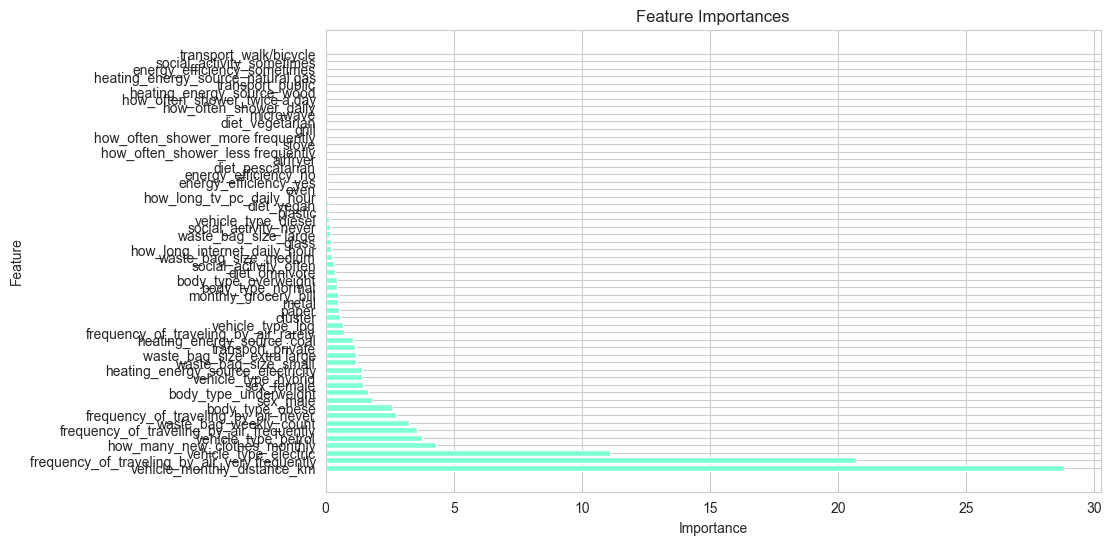


Feature Importances:
                                          Feature  Importance
1                     vehicle_monthly_distance_km   28.801979
48  frequency_of_traveling_by_air_very frequently   20.695111
38                          vehicle_type_electric   11.086505
4                    how_many_new_clothes_monthly    4.291556
41                            vehicle_type_petrol    3.752657
45       frequency_of_traveling_by_air_frequently    3.568160
2                          waste_bag_weekly_count    3.271619
46            frequency_of_traveling_by_air_never    2.736093
17                                body_type_obese    2.590694
21                                       sex_male    1.789241
19                          body_type_underweight    1.658017
20                                     sex_female    1.449941
39                            vehicle_type_hybrid    1.419003
31              heating_energy_source_electricity    1.406801
52                           waste_bag_size_smal

In [52]:
# Print DL results
print("\nDL Model Performance:")
dl_results = []
for name, preds in dl_model_predictions.items():
    mae = mean_absolute_error(y_test, preds)
    dl_results.append((name, mae))
    print(f"{name} MAE: {mae:.4f}")
print(f"Ensemble MAE: {mean_absolute_error(y_test, ensemble_pred):.4f}")

# Find the best DL model
best_dl_model_name, best_dl_mae = min(dl_results, key=lambda x: x[1])
print(f"\nBest DL Model: {best_dl_model_name} with MAE: {best_dl_mae:.4f}")

# Compare best ML and DL models
if best_ml_mae < best_dl_mae:
    print(f"\nOverall Best Model: {best_ml_model_name} with MAE: {best_ml_mae:.4f}")
    best_model = [model for name, model in models if name == best_ml_model_name][0]
else:
    print(f"\nOverall Best Model: {best_dl_model_name} with MAE: {best_dl_mae:.4f}")
    best_model = dl_models[best_dl_model_name]

# Save the best model
best_model.fit(X_train, y_train)
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Feature Importance (only for ML models)
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = X.columns

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='Aquamarine')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()

    print("\nFeature Importances:")
    print(feature_importance_df)